<a href="https://colab.research.google.com/github/lefth-nd/ml-expert-potato/blob/main/%5Bchkp8%5D_COMP2712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP2712 Practical04, Checkpoint08: Is it really better?

So, we have discovered the best parameter setting for a classifer, but is it really better than other classifiers?  What about an MLP?


## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Challenging Dataset?

As an example of support vector machines in action, let's take a look at the facial recognition problem ([http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/)). We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:


In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


View some of the faces to see "who" we are dealing with.

1348


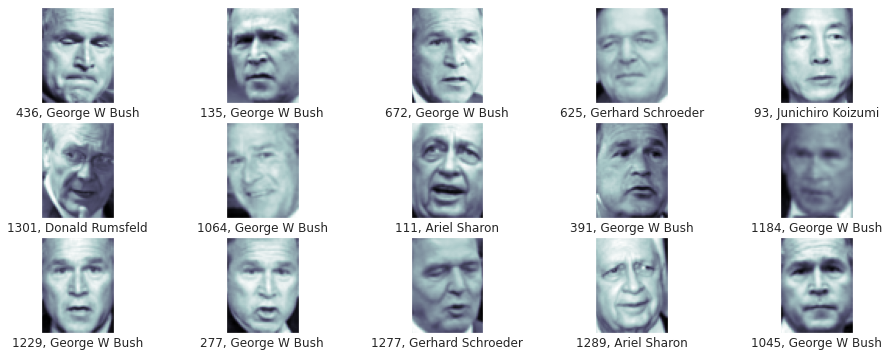

In [3]:
fig, ax = plt.subplots(3, 5, figsize=(16, 6))
nfaces = len(faces.images)
print(nfaces)
for i, axi in enumerate(ax.flat):
  i_random = random.randint(0,nfaces)
  axi.imshow(faces.images[i_random], cmap='bone')
  axi.set(xticks=[], yticks=[],
            xlabel='{}, {}'.format(i_random,faces.target_names[faces.target[i_random]]))

The shape of the data is this:

In [4]:
print(faces.images.shape)
print('{} images of size {}x{}'.format(faces.images.shape[0],faces.images.shape[1],faces.images.shape[2]))
print('which means there are {} pixels per face'.format(faces.images.shape[1]*faces.images.shape[2]))

(1348, 62, 47)
1348 images of size 62x47
which means there are 2914 pixels per face


In [5]:
62*47

2914

The faces dataset has a `data` field that has the already transformed data.  Let's check is size/shape to confirm the above...

In [6]:
faces.data.shape

(1348, 2914)

## Explore HyperParamters with GridSearch

Now let's use GridSearchCV to explore all the combinations of parameters!

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, make_scorer

X = faces.data
y = faces.target

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
std = StandardScaler()
pca = PCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf')
pipe = Pipeline([('std',std),('pca', pca),('svc',svc)])

# Parameters of pipelines can be set using '__' separated parameter names:
# read the documentation for what parameters can be modified
param_grid = {
  'pca__n_components': [5, 10, 80],
  'svc__kernel': ['linear','rbf'],
  'svc__C': [1, 10]
}

# choose a scorer to optimise the model with
scoring = 'accuracy' # default is 'accuracy'
#scoring = 'f1_macro' # default is 'accuracy'
#scoring = make_scorer(matthews_corrcoef) # similar to bookermaker informedness, ranges from -1 to 1

# set up the grid search and ensure it fits/trains to the whole datset as well (refit=True)
search = GridSearchCV(pipe, param_grid, cv=5, verbose=10, refit=True, scoring=scoring)
search.fit(X_train, y_train)

print()
print('Best parameter CV score={:0.3f}:'.format(search.best_score_))
print(search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START pca__n_components=5, svc__C=1, svc__kernel=linear..........
[CV 1/5; 1/12] END pca__n_components=5, svc__C=1, svc__kernel=linear;, score=0.404 total time=   0.1s
[CV 2/5; 1/12] START pca__n_components=5, svc__C=1, svc__kernel=linear..........
[CV 2/5; 1/12] END pca__n_components=5, svc__C=1, svc__kernel=linear;, score=0.416 total time=   0.1s
[CV 3/5; 1/12] START pca__n_components=5, svc__C=1, svc__kernel=linear..........
[CV 3/5; 1/12] END pca__n_components=5, svc__C=1, svc__kernel=linear;, score=0.416 total time=   0.1s
[CV 4/5; 1/12] START pca__n_components=5, svc__C=1, svc__kernel=linear..........
[CV 4/5; 1/12] END pca__n_components=5, svc__C=1, svc__kernel=linear;, score=0.441 total time=   0.1s
[CV 5/5; 1/12] START pca__n_components=5, svc__C=1, svc__kernel=linear..........
[CV 5/5; 1/12] END pca__n_components=5, svc__C=1, svc__kernel=linear;, score=0.386 total time=   0.2s
[CV 1/5; 2/12] START pca

## Test this best model on the testing data

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.88      0.88      0.88        59
           2       0.96      0.83      0.89        30
           3       0.81      0.99      0.89       133
           4       0.84      0.78      0.81        27
           5       0.91      0.56      0.69        18
           6       1.00      0.87      0.93        15
           7       0.96      0.67      0.79        36

    accuracy                           0.87       337
   macro avg       0.91      0.80      0.84       337
weighted avg       0.88      0.87      0.86       337

Matthews Correlation Coefficient: 0.8284067596410377


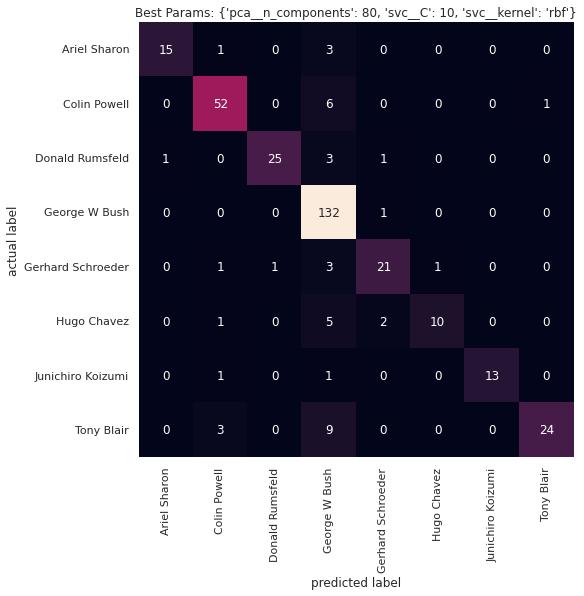

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

y_pred = search.predict(X_test)

print(classification_report(y_test,y_pred))
mcc = matthews_corrcoef(y_test,y_pred)
print('Matthews Correlation Coefficient: {}'.format(mcc))

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names,
            ax=ax)
plt.title('Best Params: {}'.format(search.best_params_))
plt.ylabel('actual label')
plt.xlabel('predicted label');

## 10x10 CV without nested CV

The above can help choose which parameter settings are the best, but still lacks the analytical ability to demonstrate the generalisablity (or a better estimate of the generalisation error to unseen data) of the classifier.  For this, we *could* do a 10x10 CV WITH the nested CV, with grid search nested CV!  

However, that takes a really, really, long time, when all we really need is to set the hyperparamters on a random subset of the data.  This is what we did about with the `train_test_split`.  So, now we just need to do the 10x10 CV

The notebook [COMP2712 Evaluating Machine Learning](https://colab.research.google.com/drive/1tbbjAMc9QetoYQRsB19KagXBz6d9Pqwl?usp=sharing) contains an example of how to use k-fold validation and you can find documentation at sckit-learn here: [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html), particularly the section on [Stratified K-Fold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold).

### 10 CV
We will start with just the 10-fold cross validation (10 CV).  In the previous practical you did this manually, well done!  Now you know how, let's do it in a more automated way using the scikit learn family of helper cross-validation functions [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate), and [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict).

Set up for the cross-validation:

In [9]:
# shuffle the dataset every time we do the 10 CV (we really want to be random)
from sklearn.utils import shuffle
X_shuf, y_shuf = shuffle(X, y)

# create a pipeline classifier model based on the best parameters
from sklearn.base import clone
model = clone(search.best_estimator_)

# stratification is always a must!
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10,shuffle=True) # inner 10



Try out each cross validation function:

In [10]:
# cross_val_score only returns a score for each fold
from sklearn.model_selection import cross_val_score

print('***** cross_val_score')
cross_val_scores = cross_val_score(model, X_shuf, y_shuf, cv=skf, verbose=3, scoring='accuracy')
print('cross_val_score: {}'.format(cross_val_scores))


***** cross_val_score


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.874) total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ................................ score: (test=0.874) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ................................ score: (test=0.904) total time=   0.5s
[CV] END ................................ score: (test=0.852) total time=   0.5s
[CV] END ................................ score: (test=0.822) total time=   0.5s
[CV] END ................................ score: (test=0.822) total time=   0.5s
[CV] END ................................ score: (test=0.904) total time=   0.5s
[CV] END ................................ score: (test=0.889) total time=   0.5s
[CV] END ................................ score: (test=0.881) total time=   0.5s
[CV] END ................................ score: (test=0.828) total time=   0.5s
cross_val_score: [0.87407407 0.87407407 0.9037037  0.85185185 0.82222222 0.82222222
 0.9037037  0.88888889 0.88059701 0.82835821]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [11]:
# cross_validate returns more information and can use multiple scorers
from sklearn.model_selection import cross_validate

print('***** cross_validate')
cross_validate_scores = cross_validate(model, X_shuf, y_shuf, cv=skf, verbose=3, scoring=('accuracy','f1_macro'))
print('cross_validate: {}'.format(cross_validate_scores))

***** cross_validate


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...... accuracy: (test=0.881) f1_macro: (test=0.850) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ...... accuracy: (test=0.837) f1_macro: (test=0.813) total time=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ...... accuracy: (test=0.911) f1_macro: (test=0.905) total time=   0.5s
[CV] END ...... accuracy: (test=0.904) f1_macro: (test=0.873) total time=   0.5s
[CV] END ...... accuracy: (test=0.830) f1_macro: (test=0.783) total time=   0.5s
[CV] END ...... accuracy: (test=0.859) f1_macro: (test=0.806) total time=   0.5s
[CV] END ...... accuracy: (test=0.896) f1_macro: (test=0.899) total time=   0.5s
[CV] END ...... accuracy: (test=0.867) f1_macro: (test=0.838) total time=   0.5s
[CV] END ...... accuracy: (test=0.903) f1_macro: (test=0.882) total time=   0.5s
[CV] END ...... accuracy: (test=0.843) f1_macro: (test=0.793) total time=   0.5s
cross_validate: {'fit_time': array([0.42275405, 0.46566963, 0.42983985, 0.43616796, 0.43774247,
       0.42929888, 0.44305539, 0.43178678, 0.45720768, 0.42779565]), 'score_time': array([0.02611065, 0.02528405, 0.02540684, 0.0255568 , 0.02612472,
       0.02557707, 0.02633429, 0.02508616, 0.02657604, 0.02632594]), 'test_accuracy': array([0.88148148, 0

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [12]:
# cross_val_predict returns the predictions for the folds
from sklearn.model_selection import cross_val_predict

print('***** cross_val_predict')
y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=3)
print('cross_val_predict: {}'.format(y_pred))




***** cross_val_predict


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


cross_val_predict: [3 3 3 ... 3 4 4]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


With `cross_val_predict` we can calculated the confusion matrix and other statistics.  Compare `y_pred` to our shuffled input data `y_shuf`.

              precision    recall  f1-score   support

           0       0.98      0.71      0.83        77
           1       0.91      0.91      0.91       236
           2       0.89      0.77      0.83       121
           3       0.82      0.98      0.90       530
           4       0.85      0.77      0.81       109
           5       1.00      0.69      0.82        71
           6       1.00      0.78      0.88        60
           7       0.92      0.80      0.86       144

    accuracy                           0.87      1348
   macro avg       0.92      0.80      0.85      1348
weighted avg       0.88      0.87      0.87      1348

Matthews Correlation Coefficient: 0.8375692988492454


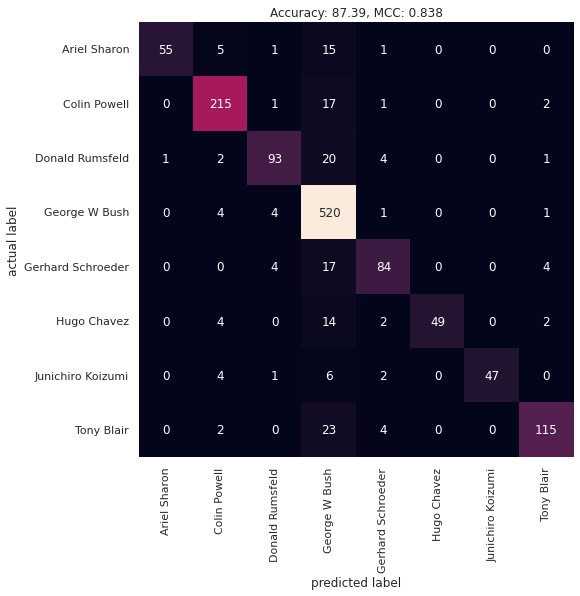

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

print(classification_report(y_shuf,y_pred))
acc = accuracy_score(y_shuf,y_pred)
mcc = matthews_corrcoef(y_shuf,y_pred)
print('Matthews Correlation Coefficient: {}'.format(mcc))

mat = confusion_matrix(y_shuf, y_pred)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names,
            ax=ax)
plt.title('Accuracy: {:.2f}, MCC: {:.3f}'.format(acc*100,mcc))
plt.ylabel('actual label')
plt.xlabel('predicted label');

### 10x10 CV

Okay, now that we can do a 10 CV let's do the final outer 10 so that we can calculate some statistics on the performance of this classifier model.

# **SVM**

In [14]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

n_outer =  10 # this should be 10 for the "10"x 10 CV, you could use a smaller values, say 2, for prototyping
n_splits = 10 # this should be 10 for the 10 x "10" CV, you could use a smaller values, say 2, for prototyping
acc_outer_svm = []
f1_outer_svm  = []
mcc_outer_svm  = []

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(X, y)

  # create a pipeline classifier model based on the best parameters
  model = clone(search.best_estimator_)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat_svm = confusion_matrix(y_shuf, y_pred)

  acc_outer_svm.append(acc)
  f1_outer_svm.append(f1)
  mcc_outer_svm.append(mcc)

print('SVM Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_svm)*100,np.std(acc_outer_svm)*100))
print('SVM Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_svm),np.std(f1_outer_svm)))
print('SVM Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_svm),np.std(mcc_outer_svm)))


#### Outer Iteration 1 of 10
***** cross_val_predict
#### Outer Iteration 2 of 10
***** cross_val_predict
#### Outer Iteration 3 of 10
***** cross_val_predict
#### Outer Iteration 4 of 10
***** cross_val_predict
#### Outer Iteration 5 of 10
***** cross_val_predict
#### Outer Iteration 6 of 10
***** cross_val_predict
#### Outer Iteration 7 of 10
***** cross_val_predict
#### Outer Iteration 8 of 10
***** cross_val_predict
#### Outer Iteration 9 of 10
***** cross_val_predict
#### Outer Iteration 10 of 10
***** cross_val_predict
SVM Outer accuracy M = 87.14, SD = 0.3400
SVM Outer F1-Score M = 0.848, SD = 0.0047
SVM Outer MCC      M = 0.834, SD = 0.0045


In [15]:
print(f1_outer_svm)

[0.8490498828902526, 0.8493582716277499, 0.8564489399424539, 0.8407581748805394, 0.8439288316325287, 0.843942476290509, 0.8491034645570736, 0.8533388486836627, 0.8437084990570511, 0.8509498127425827]


## Comparing Classifiers

Now, comes the tricky bit of this practical! Adapt the code above to train an optimal neural network classifier (see the previous practicals).  Take the ten f1 scores from the outer loop of the neural neural network and perform a t-test between the SVM and the ANN.  Are the differences significant?

In [16]:
#t-test?

# **MLP**

## TASK
Implement the grid search for the ANN and perform a 10x10 CV using that grid search.

Report the overall performance (accuracy, F1-score, MCC) for the SVM and ANN and if the difference is significant (that is, p < 0.05).

### Implement GridSearchCV for MLP Hyperparameters

In [59]:
# your code here

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

pipe = Pipeline([('std',std),('mlp', mlp)])

param_grid = {
    'mlp__solver': ['adam', 'sgd'],
    'mlp__max_iter': [100, 120],
    'mlp__hidden_layer_sizes': [30, 45],
    'mlp__activation': ['tanh', 'relu']
}

search = GridSearchCV(pipe, param_grid, cv=10, verbose=10, scoring='f1_macro')
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)


Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.784 total time=   1.7s
[CV 2/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.808 total time=   2.5s
[CV 3/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.752 total time=   2.7s
[CV 4/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.780 total time=   1.6s
[CV 5/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.803 total time=   1.7s
[CV 6/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.903 total time=   1.7s
[CV 7/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.881 total time=   1.6s
[CV 8/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.799 total time=   1.7s
[CV 9/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.731 total time=   1.7s
[CV 10/10; 1/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 1/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.745 total time=   1.7s
[CV 1/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.749 total time=   1.6s
[CV 2/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.728 total time=   1.5s
[CV 3/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.755 total time=   1.5s
[CV 4/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.696 total time=   1.5s
[CV 5/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.732 total time=   1.5s
[CV 6/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.891 total time=   1.5s
[CV 7/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.772 total time=   1.5s
[CV 8/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.773 total time=   2.1s
[CV 9/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.764 total time=   1.5s
[CV 10/10; 2/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 2/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.722 total time=   1.5s
[CV 1/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.773 total time=   1.9s
[CV 2/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.800 total time=   2.0s
[CV 3/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.744 total time=   2.0s
[CV 4/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.725 total time=   2.0s
[CV 5/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.785 total time=   2.0s
[CV 6/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.931 total time=   1.9s
[CV 7/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.866 total time=   1.9s
[CV 8/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.790 total time=   2.0s
[CV 9/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.706 total time=   2.0s
[CV 10/10; 3/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 3/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.750 total time=   1.9s
[CV 1/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.752 total time=   1.8s
[CV 2/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.765 total time=   1.7s
[CV 3/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.676 total time=   1.8s
[CV 4/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.750 total time=   1.8s
[CV 5/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.744 total time=   1.8s
[CV 6/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.859 total time=   2.3s
[CV 7/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.792 total time=   1.8s
[CV 8/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.751 total time=   1.8s
[CV 9/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.817 total time=   1.8s
[CV 10/10; 4/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 4/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.745 total time=   1.8s
[CV 1/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.800 total time=   2.0s
[CV 2/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.791 total time=   2.0s
[CV 3/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.796 total time=   2.0s
[CV 4/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.730 total time=   2.0s
[CV 5/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.746 total time=   2.1s
[CV 6/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.908 total time=   2.0s
[CV 7/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.851 total time=   2.1s
[CV 8/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.812 total time=   2.0s
[CV 9/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.749 total time=   2.0s
[CV 10/10; 5/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 5/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.766 total time=   2.1s
[CV 1/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.775 total time=   1.9s
[CV 2/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.757 total time=   1.9s
[CV 3/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.724 total time=   1.9s
[CV 4/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.727 total time=   1.9s
[CV 5/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.746 total time=   1.9s
[CV 6/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.893 total time=   1.8s
[CV 7/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.852 total time=   1.8s
[CV 8/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.792 total time=   1.8s
[CV 9/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.722 total time=   1.8s
[CV 10/10; 6/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 6/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.734 total time=   1.9s
[CV 1/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 1/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.798 total time=   2.3s
[CV 2/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.806 total time=   2.4s
[CV 3/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.781 total time=   2.4s
[CV 4/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.808 total time=   2.4s
[CV 5/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.788 total time=   2.4s
[CV 6/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.929 total time=   2.4s
[CV 7/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.834 total time=   2.4s
[CV 8/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.824 total time=   2.4s
[CV 9/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 9/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.732 total time=   2.3s
[CV 10/10; 7/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 10/10; 7/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.755 total time=   2.3s
[CV 1/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.791 total time=   2.2s
[CV 2/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.806 total time=   2.2s
[CV 3/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.742 total time=   2.2s
[CV 4/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.804 total time=   2.2s
[CV 5/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.766 total time=   2.2s
[CV 6/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.923 total time=   2.2s
[CV 7/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.793 total time=   2.1s
[CV 8/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.763 total time=   2.1s
[CV 9/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.730 total time=   2.2s
[CV 10/10; 8/16] START mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 8/16] END mlp__activation=tanh, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.791 total time=   2.1s
[CV 1/10; 9/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam
[CV 1/10; 9/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.732 total time=   1.4s
[CV 2/10; 9/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam
[CV 2/10; 9/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.761 total time=   1.3s
[CV 3/10; 9/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam
[CV 3/10; 9/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam;, score=0.677 total time=   1.3s
[CV 4/10; 9/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=adam
[CV 4/10; 9/

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.748 total time=   1.4s
[CV 2/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.784 total time=   1.4s
[CV 3/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.700 total time=   1.4s
[CV 4/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.714 total time=   1.5s
[CV 5/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.717 total time=   1.5s
[CV 6/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.811 total time=   1.5s
[CV 7/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.730 total time=   1.5s
[CV 8/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.780 total time=   1.5s
[CV 9/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.741 total time=   1.5s
[CV 10/10; 10/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 10/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=100, mlp__solver=sgd;, score=0.730 total time=   1.5s
[CV 1/10; 11/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam
[CV 1/10; 11/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.756 total time=   1.4s
[CV 2/10; 11/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam
[CV 2/10; 11/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.792 total time=   1.4s
[CV 3/10; 11/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam
[CV 3/10; 11/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam;, score=0.742 total time=   1.5s
[CV 4/10; 11/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=adam
[CV 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.670 total time=   1.8s
[CV 2/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.724 total time=   1.8s
[CV 3/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.650 total time=   1.8s
[CV 4/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.743 total time=   1.8s
[CV 5/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.751 total time=   1.7s
[CV 6/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.851 total time=   1.8s
[CV 7/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.855 total time=   1.7s
[CV 8/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.706 total time=   1.7s
[CV 9/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.731 total time=   1.8s
[CV 10/10; 12/16] START mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 12/16] END mlp__activation=relu, mlp__hidden_layer_sizes=30, mlp__max_iter=120, mlp__solver=sgd;, score=0.736 total time=   1.8s
[CV 1/10; 13/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam
[CV 1/10; 13/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.761 total time=   1.4s
[CV 2/10; 13/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam
[CV 2/10; 13/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.752 total time=   1.5s
[CV 3/10; 13/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam
[CV 3/10; 13/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam;, score=0.704 total time=   1.3s
[CV 4/10; 13/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=adam
[CV 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.718 total time=   1.8s
[CV 2/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.735 total time=   1.7s
[CV 3/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.701 total time=   1.8s
[CV 4/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.728 total time=   1.8s
[CV 5/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.766 total time=   1.8s
[CV 6/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.876 total time=   1.8s
[CV 7/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.836 total time=   1.7s
[CV 8/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.809 total time=   1.8s
[CV 9/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.695 total time=   1.7s
[CV 10/10; 14/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 14/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=100, mlp__solver=sgd;, score=0.672 total time=   1.7s
[CV 1/10; 15/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 1/10; 15/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.776 total time=   1.4s
[CV 2/10; 15/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 2/10; 15/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.745 total time=   1.3s
[CV 3/10; 15/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 3/10; 15/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam;, score=0.677 total time=   1.5s
[CV 4/10; 15/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=adam
[CV 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.688 total time=   2.1s
[CV 2/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.784 total time=   2.1s
[CV 3/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.672 total time=   2.1s
[CV 4/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.708 total time=   3.3s
[CV 5/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.728 total time=   2.5s
[CV 6/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 6/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.792 total time=   2.0s
[CV 7/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 7/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.876 total time=   2.1s
[CV 8/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 8/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.775 total time=   2.8s
[CV 9/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 9/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.694 total time=   2.1s
[CV 10/10; 16/16] START mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 10/10; 16/16] END mlp__activation=relu, mlp__hidden_layer_sizes=45, mlp__max_iter=120, mlp__solver=sgd;, score=0.793 total time=   2.1s
0.8054602937933304
{'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': 45, 'mlp__max_iter': 120, 'mlp__solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [18]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'std', 'pca', 'svc', 'std__copy', 'std__with_mean', 'std__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

### Implement 10x10 CV for the MLP

In [60]:

# do the 10x10 CV for the MLP
# your code here
n_outer =  10 # this should be 10 for the "10"x 10 CV, you could use a smaller values, say 2, for prototyping
n_splits = 10 # this should be 10 for the 10 x "10" CV, you could use a smaller values, say 2, for prototyping
acc_outer_mlp = []
f1_outer_mlp  = []
mcc_outer_mlp  = []

for i_outer in range(0,n_outer):

  print('#### Outer Iteration {} of {}'.format(i_outer+1,n_outer))

  # shuffle the dataset every time we do the 10 CV (we really want to be random)
  X_shuf, y_shuf = shuffle(X, y)

  # create a pipeline classifier model based on the best parameters
  model = clone(search.best_estimator_)

  # stratification is always a must!
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True) # inner 10

  # cross_val_predict returns the predictions for the folds
  print('***** cross_val_predict')
  y_pred = cross_val_predict(model, X_shuf, y_shuf, cv=skf, verbose=0)

  

  acc = accuracy_score(y_shuf,y_pred)
  f1 = f1_score(y_shuf,y_pred,average='macro')
  mcc = matthews_corrcoef(y_shuf,y_pred)
  mat_mlp = confusion_matrix(y_shuf, y_pred)

  acc_outer_mlp.append(acc)
  f1_outer_mlp.append(f1)
  mcc_outer_mlp.append(mcc)

# report the results
print('MLP Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_mlp)*100,np.std(acc_outer_mlp)*100))
print('MLP Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_mlp),np.std(f1_outer_mlp)))
print('MLP Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_mlp),np.std(mcc_outer_mlp)))

#### Outer Iteration 1 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 2 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 3 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 4 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 5 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 6 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 7 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 8 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 9 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

#### Outer Iteration 10 of 10
***** cross_val_predict


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

MLP Outer accuracy M = 84.40, SD = 0.4988
MLP Outer F1-Score M = 0.813, SD = 0.0080
MLP Outer MCC      M = 0.802, SD = 0.0065


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [58]:
print(mat_mlp)

[[ 63   6   4   0   1   2   0   1]
 [  5 210   2  11   1   3   1   3]
 [  4   5  98   6   4   1   0   3]
 [  2  19  16 463   6   9   6   9]
 [  0   1   2   7  91   2   1   5]
 [  0   4   0   4   5  54   1   3]
 [  1   2   0   1   3   0  51   2]
 [  0   3   4   7   8   0   2 120]]


In [20]:
print(f1_outer_mlp)

[0.8278450422110832, 0.8236740954143752, 0.8204915565946226, 0.8153361758646329, 0.8184797983960921, 0.8081618778405413, 0.8268505010224767, 0.8229003888076959, 0.8176880013929102, 0.8264145301031204]


## Is it really differnet? Testing for "significant" differences!

[https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)


"We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages."

See the following notebook for an example of evaluating significance:
https://colab.research.google.com/drive/1t4LMyy_8R9O7fgKleSY7GWn3v7Wlm9Ih?usp=sharing


### Compare the performance of SVM and MLP using statistics

Answer the question...is it really better?

In [61]:
print('SVM Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_svm)*100,np.std(acc_outer_svm)*100))
print('SVM Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_svm),np.std(f1_outer_svm)))
print('SVM Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_svm),np.std(mcc_outer_svm)))

SVM Outer accuracy M = 87.14, SD = 0.3400
SVM Outer F1-Score M = 0.848, SD = 0.0047
SVM Outer MCC      M = 0.834, SD = 0.0045


In [62]:
print('MLP Outer accuracy M = {:.2f}, SD = {:.4f}'.format(np.mean(acc_outer_mlp)*100,np.std(acc_outer_mlp)*100))
print('MLP Outer F1-Score M = {:.3f}, SD = {:.4f}'.format(np.mean(f1_outer_mlp),np.std(f1_outer_mlp)))
print('MLP Outer MCC      M = {:.3f}, SD = {:.4f}'.format(np.mean(mcc_outer_mlp),np.std(mcc_outer_mlp)))

MLP Outer accuracy M = 84.40, SD = 0.4988
MLP Outer F1-Score M = 0.813, SD = 0.0080
MLP Outer MCC      M = 0.802, SD = 0.0065


In [23]:
from scipy import stats

{'whiskers': [<matplotlib.lines.Line2D at 0x7f999cb26d50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f999cb2dc90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f999cb26bd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f999cb32790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f999cb32cd0>],
 'means': []}

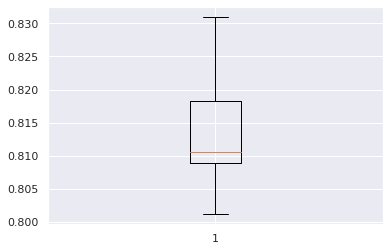

In [63]:
plt.boxplot(f1_outer_mlp)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f999ca8d4d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f999ca8df50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f999ca87ed0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f999ca93a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f999ca93f90>],
 'means': []}

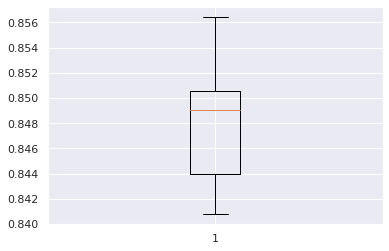

In [64]:
plt.boxplot(f1_outer_svm)

In [65]:
stats.ttest_ind(f1_outer_svm, f1_outer_mlp)

Ttest_indResult(statistic=11.27156498675529, pvalue=1.373598199318539e-09)

In [66]:
stats.ttest_ind(mcc_outer_svm, mcc_outer_mlp)

Ttest_indResult(statistic=12.256212849830323, pvalue=3.588875937052287e-10)

In [54]:
print(mcc_outer_svm)

[0.837364554806794, 0.8342280800787703, 0.8402217252768072, 0.8254584575415628, 0.8315009239403413, 0.8295889081330714, 0.8342938989275112, 0.8412469164280127, 0.8332958112171367, 0.833372368496303]


In [53]:
print(mcc_outer_mlp)

[0.7949693097398544, 0.7814808005100553, 0.8135382228048189, 0.7943110502008648, 0.7969966365887682, 0.799028352557575, 0.8054054718242316, 0.7952538918748183, 0.8044190061679484, 0.8137254606619954]
